# Chapter 4 Training Models

## Linear Regression

A linear model makes a prediction by simply computing a weighted sum of the input features, plus a constant called the *bias term*: 

$$ \hat{y}=\theta_0 + \theta_1 x_1 + \theta_2 x_2 + ... + \theta_n x_n $$

In this equation: $\hat{y}$ is the predicted value, $n$ is the number of features, $x_i$ is the i-th feature value, and $\theta_j$ is the j-th model parameter (including the bias term $\theta_0$).

In vectorized form:
$$ \hat{y} = h_{\mathbf{\theta}}(\mathbf{x})=\mathbf{\theta}\cdot\mathbf{x} $$

If $\mathbf{\theta}$ and $\mathbf{x}$ are column vectors, then the prediction is $\hat{y}=\mathbf{\theta}^{\text{T}}\mathbf{x}$, where $\mathbf{\theta}^{\text{T}}$ is the transpose of $\mathbf{\theta}$ and $\mathbf{\theta}^{\text{T}}\mathbf{x}$ is the matrix multiplication of the two vectors.

In order to train a linear regression model we first need a measure of how well (or poorly) the model fits the training data. The most common performance measure of a regression model is the Root Mean Square Error (RMSE). We need to find the value of $\mathbf{\theta}$ that minimizes the RMSE. In practice, it is simpler to minimize the mean squared error (MSE) rather than the RMSE.

The MSE of a linear regression hypothesis $h_{\mathbf{\theta}}$ on a training set $\mathbf{X}$ is:

$$ MSE(\mathbf{X}, h_{\mathbf{\theta}})=\frac{1}{m}\sum^{m}_{i=1}\big(\mathbf{\theta}^{\text{T}}\mathbf{x}^{(i)}-y^{(i)}\big)^{2}$$

To find the value of $\mathbf{\theta}$ that minimizes the cost function, there is a closed-form solution known as the *Normal Equation*.

$$ \hat{\mathbf{\theta}}=(\mathbf{X}^{\text{T}}\mathbf{X})^{-1}\mathbf{X}^{\text{T}}\mathbf{y} $$

Let's use the normal equation to perform regression on some test data in Python:

(0.0, 2.0, 0.0, 15.0)

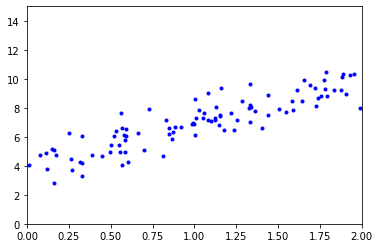

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

plt.plot(X, y, 'b.')
plt.axis([0, 2, 0, 15])

In [2]:
X_b = np.c_[np.ones((100, 1)), X]  # add x0 = 1 to each instance
print(X_b[:5])

[[1.         0.25187542]
 [1.         0.60486071]
 [1.         0.31435487]
 [1.         0.11622362]
 [1.         0.5798214 ]]


In [3]:
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[3.99478647],
       [2.95121193]])

The function that we used to generate the data is $y=4+3x_{1}+\text{Gaussian noise}$. Now we can make predictions using $\hat{\mathbf{\theta}}$:

In [4]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[3.99478647],
       [9.89721033]])

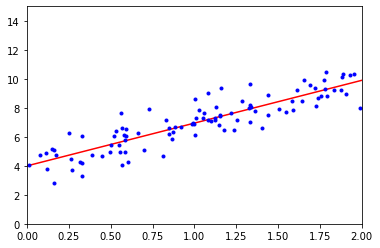

In [5]:
plt.plot(X_new, y_predict, 'r-')
plt.plot(X, y, 'b.')
plt.axis([0, 2, 0, 15])
plt.show()

We can also perform linear regression with Scikit-Learn:

In [6]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([3.99478647]), array([[2.95121193]]))

In [7]:
lin_reg.predict(X_new)

array([[3.99478647],
       [9.89721033]])

The `LinearRegression` class is actually based on the `scipy.linalg.lstsq()` function. We can call that directly too:

In [8]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[3.99478647],
       [2.95121193]])

This function computes $\hat{\mathbf{\theta}}=\mathbf{X}^{+}\mathbf{y}$, where $\mathbf{X}^{+}$ is the *pseudoinverse* of $\mathbf{X}$. We can use `np.linalg.pinv()` to compute the pseudoinverse directly:

In [9]:
np.linalg.pinv(X_b).dot(y)

array([[3.99478647],
       [2.95121193]])

## Computational Complexity

The normal equation computes the inverse of $\mathbf{X}^{\text{T}}\mathbf{X}$, which is an $(n+1)\times (n+1)$ matrix (where $n$ is the number of features).

The computational complexity of inverting such a matrix is typically $O(n^{2.4})$ to $O(n^{3})$. The SVD approach used by Scikit-Learn's `LinearRegression` class if about $O(n^2)$. 

While both the Normal Equation and SVD approach get very slow with increasing number of features, both are linear with regard to the number of instances in the training set (they are $O(m)$, so they can handle large training sets efficiently, provided they can fit in memory.

Making predictions with a trained model, however, is very fast ($O(m)$).

When there are a large number of features or too many training instances to fit in memory we have to get creative in order to reduce computational complexity and the training time.

## Gradient Descent

